 Disaster Tweets NLP Pipeline – Google Colab Starter
 ==================================================
 This script lays a complete, end‑to‑end foundation for the Kaggle competition
 **"Natural Language Processing with Disaster Tweets"**
 https://www.kaggle.com/c/nlp-getting-started

 ▸ Runs out‑of‑the‑box in **Google Colab** (Python 3.10, GPU optional)
 ▸ Handles: data download, EDA, preprocessing, classical & deep‑learning models,
   hyper‑parameter search, and Kaggle submission file creation.
 ▸ Written as a single Python file with `# %%` cell markers so you can
   **"File ▶ Open Notebook"** in Colab and it will render as a notebook.👩‍💻

# --------------------------------------------------
#  Table of Contents (⌘/Ctrl + F → "# %%")
# --------------------------------------------------
 00 | Environment & Dependencies
 01 | Kaggle API Authentication & Data Download
 02 | Imports & Global Config
 03 | Load Data
 04 | Quick Data Overview
 05 | Exploratory Data Analysis (EDA)
 06 | Text Cleaning & Pre‑processing
 07 | Train/Validation Split
 08 | Classical Baseline – TF‑IDF + LogReg
 09 | Deep Learning Model – Bi‑LSTM
 10 | Hyper‑parameter Tuning with Keras Tuner (Optional)
 11 | Evaluation & Error Analysis
 12 | Generate Submission CSV
 13 | (Extra) Experiment Tracker & References
 ==================================================

In [7]:
!pip install -q kaggle keras-tuner wordcloud nltk emoji
!python -m nltk.downloader punkt stopwords wordnet omw-1.4
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 22.9 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
from google.colab import files, auth
import os, json, pathlib, textwrap

uploaded = files.upload()

path = pathlib.Path.home()/'.kaggle'
path.mkdir(exist_ok=True)
fname = list(uploaded.keys())[0]\
os.rename(fname, path/'kaggle.json')
os.chmod(path/'kaggle.json', 0o600)

print(textwrap.dedent(f"""
  ✅  kaggle.json installed at {path}
  You can now run kaggle commands, e.g.
      !kaggle competitions download -c nlp-getting-started -p data --force
"""))


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv

✅  kaggle.json installed at /root/.kaggle
You can now run kaggle commands, e.g.
    !kaggle competitions download -c nlp-getting-started -p data --force



In [9]:
import os
from pathlib import Path

DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

if not (DATA_DIR / 'train.csv').exists():
    !kaggle competitions download -c nlp-getting-started -p data --force
    !unzip -o data/nlp-getting-started.zip -d data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 441, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 492, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.
unzip:  cannot find or open data/nlp-getting-started.zip, data/nlp-getting-started.zip.zip or data/nlp-getting-started.zip.ZIP.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.5 MB/s eta 0:00:00


In [10]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

try:
    import kerastuner as kt  # Colab installs keras-tuner package
except ImportError:
    import keras_tuner as kt

sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [12]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
train_df.head()

Train shape: (7613, 5) | Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


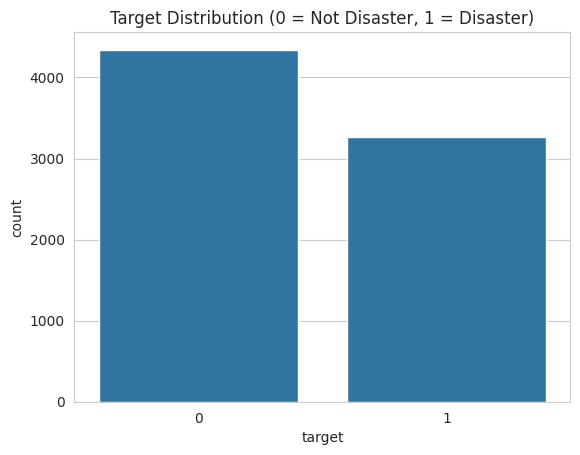

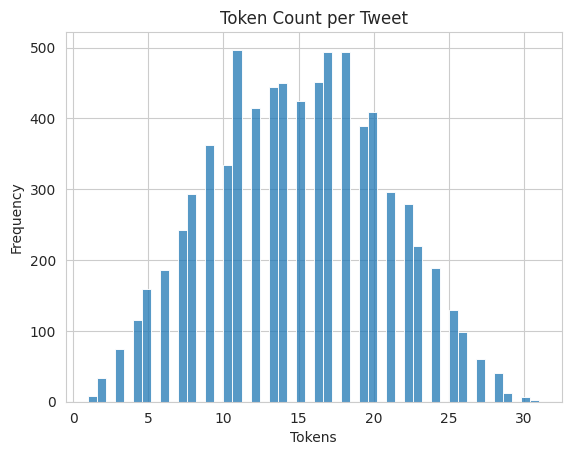

In [13]:
print(train_df.info())
print("\nMissing values:\n", train_df.isnull().sum())

# Class balance
sns.countplot(x='target', data=train_df)
plt.title('Target Distribution (0 = Not Disaster, 1 = Disaster)')
plt.show()

# Text length histogram
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))
sns.histplot(train_df['text_len'], bins=50)
plt.title('Token Count per Tweet')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.show()

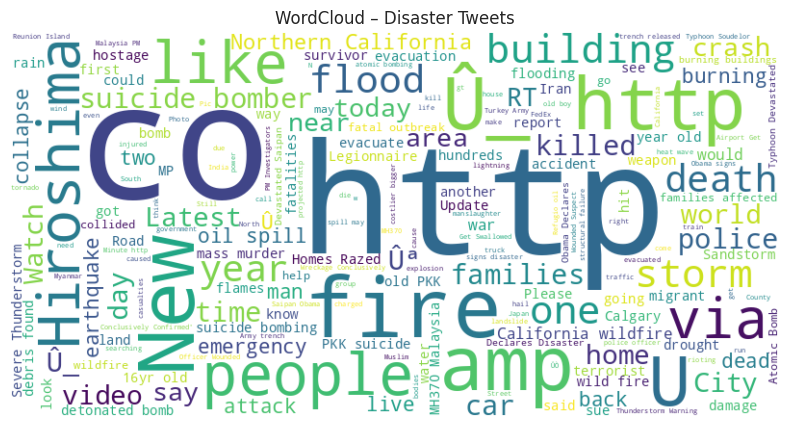

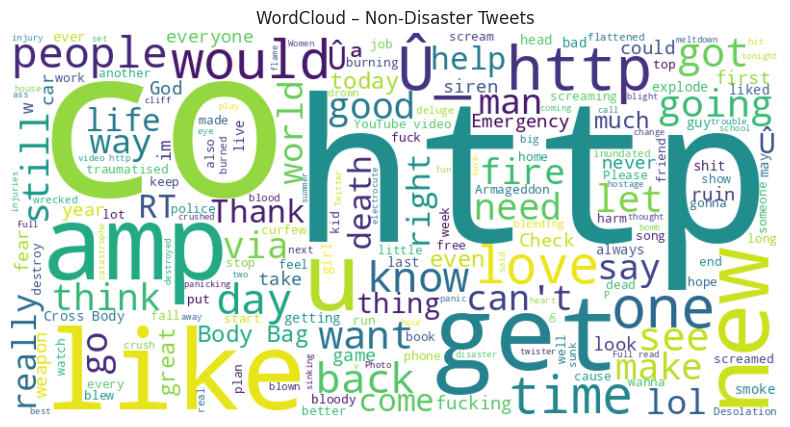

                bi_gram  count
18              û_ http    217
1     burning buildings     60
13       suicide bomber     59
17        youtube video     43
15           video http     42
5         liked youtube     42
10  northern california     41
3            cross body     40
11            oil spill     39
14      suicide bombing     36


In [14]:
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def generate_wordcloud(text_series, title):
    text = " ".join(text_series)
    wc = WordCloud(stopwords=STOPWORDS, background_color='white', height=400, width=800).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# WordClouds
generate_wordcloud(train_df[train_df.target==1]['text'], 'WordCloud – Disaster Tweets')
generate_wordcloud(train_df[train_df.target==0]['text'], 'WordCloud – Non‑Disaster Tweets')

# Top bi‑grams example
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)
X_ngrams = vectorizer.fit_transform(train_df['text'])
counts = np.asarray(X_ngrams.sum(axis=0)).ravel()
bi_grams = pd.DataFrame({'bi_gram': vectorizer.get_feature_names_out(), 'count': counts})
print(bi_grams.sort_values('count', ascending=False).head(10))


In [15]:
URL_PATTERN = r'https?://\S+|www\.\S+'
MENTION_PATTERN = r'@\w+'
HASHTAG_PATTERN = r'#\w+'
PUNCT_TABLE = str.maketrans('', '', string.punctuation)


def clean_text(text):
    text = re.sub(URL_PATTERN, '', text)
    text = re.sub(MENTION_PATTERN, '', text)
    text = re.sub(HASHTAG_PATTERN, '', text)
    text = text.translate(PUNCT_TABLE)  # remove punctuation
    text = text.lower()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in STOPWORDS]
    return " ".join(tokens)

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text']  = test_df['text'].apply(clean_text)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_text'], train_df['target'], test_size=0.2, random_state=SEED, stratify=train_df['target']
)
print(f'Train size: {len(X_train):,} | Validation size: {len(X_val):,}')


Train size: 6,090 | Validation size: 1,523


In [17]:
from sklearn.pipeline import Pipeline

baseline_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20_000, ngram_range=(1,2))),
    ('lr',    LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, random_state=SEED))
])

baseline_clf.fit(X_train, y_train)
val_pred = baseline_clf.predict(X_val)
print("Baseline (LogReg + TF-IDF) Validation Metrics:\n",
      classification_report(y_val, val_pred))


Baseline (LogReg + TF-IDF) Validation Metrics:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       869
           1       0.79      0.76      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 50_000
MAX_LEN   = 50

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert texts to padded sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(test_df['clean_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

# Optional: load GloVe 6B 100 dim
USE_GLOVE = False  # flip to True after downloading glove.6B.100d.txt
EMBED_DIM = 100 if USE_GLOVE else 64

embedding_matrix = None
if USE_GLOVE:
    GLOVE_PATH = 'glove.6B.100d.txt'  # upload or wget
    embeddings_index = {}
    with open(GLOVE_PATH, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
    embedding_matrix = np.random.normal(size=(vocab_size, EMBED_DIM))
    for word, i in tokenizer.word_index.items():
        if i >= vocab_size: continue
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

# Build model
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
inputs = layers.Input(shape=(MAX_LEN,))
if USE_GLOVE:
    x = layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM,
                         weights=[embedding_matrix], trainable=False)(inputs)
else:
    x = layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM)(inputs)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10, batch_size=128,
    callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

# Evaluate
val_probs = model.predict(X_val_pad, verbose=0).ravel()
val_pred  = (val_probs > 0.5).astype(int)
print("Bi-LSTM Validation Metrics:\n", classification_report(y_val, val_pred))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 64)         │       849,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,713 (3.52 MB)

 Trainable params: 923,713 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.5758 - loss: 0.6833 - val_accuracy: 0.7577 - val_loss: 0.6223
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.7474 - loss: 0.5766 - val_accuracy: 0.7925 - val_loss: 0.4668
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.8673 - loss: 0.3397 - val_accuracy: 0.7748 - val_loss: 0.5365
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9238 - loss: 0.2248 - val_accuracy: 0.7708 - val_loss: 0.6169
Bi-LSTM Validation Metrics:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       869
           1       0.77      0.73      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



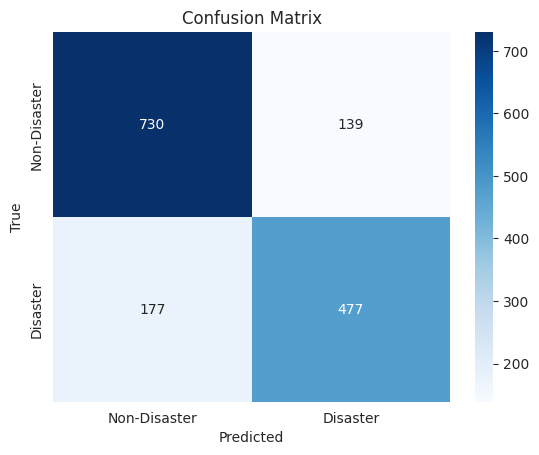


False Positives:
                                                    text      prob
4863           step one get mass murderer portrait yuan  0.531529
1370  ted cruz fire back jeb amp bush ûïwe lose rep...  0.565177
4668  megalpolis area petting party shiver fear inst...  0.539718
1358  firefighter acted like cop theyd drive around ...  0.854660
244   maybe call israel tell sorry pres sold river a...  0.529335

False Negatives:
                                                    text      prob
6837  hollywood movie trapped miner released chile 3...  0.148291
2905                         cant drown demon know swim  0.088872
1956       need plant pacific cyclone season would help  0.281583
6569  dear name humanityi apologized survivorsr u ready  0.177192
5020                      look like mudslide poor thing  0.142238


In [19]:
cm = confusion_matrix(y_val, val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Disaster','Disaster'], yticklabels=['Non-Disaster','Disaster'])
plt.ylabel('True'); plt.xlabel('Predicted'); plt.title('Confusion Matrix')
plt.show()

# Show some false positives / negatives to inspect
val_df = pd.DataFrame({'text': X_val, 'true': y_val, 'pred': val_pred, 'prob': val_probs})
false_pos = val_df[(val_df.true==0) & (val_df.pred==1)].head()
false_neg = val_df[(val_df.true==1) & (val_df.pred==0)].head()
print("\nFalse Positives:\n", false_pos[['text','prob']])
print("\nFalse Negatives:\n", false_neg[['text','prob']])

In [20]:
submit_probs = model.predict(X_test_pad, verbose=0).ravel()
submit_preds = (submit_probs > 0.5).astype(int)

submission = pd.DataFrame({'id': test_df.id, 'target': submit_preds})
submission.to_csv('submission.csv', index=False)

